In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from imblearn.over_sampling import SMOTE

from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn import model_selection

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
! pip install shap
import shap
import pickle



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from skle

     |████████████████████████████████| 356 kB 5.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491651 sha256=fa0e914ce89b7664592ed3c90309a443e6f0a53d2e0d216fbc6ff93baed28b46
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


**Fonctions**

In [4]:
def model (mdl, name, X_name, y_name, X_test_name):
  
  global nm, accuracy, recall, precision, f1,roc_auc, elapsed_train, elapsed_test, confusion, weights
  
  nm = name
  model = mdl
  X_train = X_name
  y_train = y_name
  X_test = X_test_name

  start_time = timeit.default_timer()

  model.fit(X_train, y_train)

  elapsed_train = timeit.default_timer() - start_time

  start_time = timeit.default_timer()

  y_pred = model.predict(X_test)

  elapsed_test = timeit.default_timer() - start_time


  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred, zero_division=0)
  precision = precision_score(y_test, y_pred, zero_division=0)
  f1 = f1_score(y_test,y_pred, zero_division=0)
  roc_auc = roc_auc_score(y_test, y_pred)
  
  confusion = confusion_matrix(y_test, y_pred)
  weights = (confusion.ravel()[0]*a + confusion.ravel()[1]*b + confusion.ravel()[2]*c + confusion.ravel()[3]*d) / (a+b+c+d)


def custom_metric(y_test, y_pred):

  data = confusion_matrix(y_test, y_pred)

  return (data.ravel()[0]*a + data.ravel()[1]*b + data.ravel()[2]*c + data.ravel()[3]*d) / (a+b+c+d)


def model_opti (mdl, name, X_name, y_name, params, cv_val):
  
  global nm, accuracy, recall, precision, f1,roc_auc, elapsed_train, elapsed_test, confusion, weights, best_params, best_mdl
  
  nm = name
  model = mdl
  X_train = X_name
  y_train = y_name

  params_grid = params

  grid = GridSearchCV(model,params_grid, cv = cv_val, scoring = custom_scorer)

  start_time = timeit.default_timer()

  grid.fit(X_train,y_train)

  elapsed_train = timeit.default_timer() - start_time

  start_time = timeit.default_timer()

  y_pred = grid.best_estimator_.predict(X_test_std)

  elapsed_test = timeit.default_timer() - start_time

  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred, zero_division=0)
  precision = precision_score(y_test, y_pred, zero_division=0)
  f1 = f1_score(y_test,y_pred, zero_division=0)
  roc_auc = roc_auc_score(y_test, y_pred)
  
  confusion = confusion_matrix(y_test, y_pred)
  weights = (confusion.ravel()[0]*a + confusion.ravel()[1]*b + confusion.ravel()[2]*c + confusion.ravel()[3]*d) / (a+b+c+d)
  
  best_params = grid.best_params_
  best_mdl = grid.best_estimator_

**Import Dataset**

In [5]:
app_train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/df_final.csv")
app_train = app_train[app_train.columns[1:]]

In [6]:
app_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,...,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,AMT_PAYMENT,CNT_INSTALMENT,AMT_APPLICATION,AMT_DOWN_PAYMENT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL,PERIOD,OVER_EXPECT_CREDIT,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOYED_INTERVEL,INCOME_PER_FAMILY_MEMBER,CHILDREN_RATIO
0,100002.0,1.0,0,1,0,1,406597.5,24700.5,6,7,4,3,1,0.018801,-3648.0,-2120.0,20.423145,1.0,1.0,0.0,1.0,1.0,0.0,8,2.0,6,10.0,0.0,0.0,0.0,0.0,5,0.083037,0.262949,0.139376,0.025200,0.038300,0.972200,0.634100,0.014400,...,-349.000000,-697.500000,1681.029000,0.000000,108131.945625,49156.200000,7997.141250,0.000000,-499.875000,2,-9.774510,131079.249750,179887.555152,16470.516557,3.016699,1.990798,-7.322679,1.908601,1.052632,-295.000000,11559.247105,24.000000,179055.000,0.00,1.0,0.000000,500.000000,24.000000,365243.0,-565.000000,125.000000,-25.000000,0.000000,16.461104,1.0,1.0,1.0,8824.0,202500.0,0.0
1,100003.0,0.0,0,0,0,0,1293502.5,35698.5,1,4,1,1,1,0.003541,-1186.0,-291.0,15.263779,1.0,1.0,0.0,1.0,1.0,0.0,3,1.0,1,11.0,0.0,0.0,0.0,0.0,39,0.311267,0.622246,0.533242,0.092400,0.053800,0.985100,0.804000,0.049700,...,-544.500000,-1097.333333,0.000000,0.000000,254350.125000,0.000000,202500.000000,0.000000,-816.000000,2,-24.999958,97454.912934,274194.442897,37641.500718,3.408183,9.521108,27.448312,1.454572,1.040000,-1378.160000,64754.586000,10.107143,435436.500,3442.50,1.0,0.050030,533.000000,10.000000,365243.0,-1274.333333,-1004.333333,-1054.333333,0.666667,36.234085,1.0,1.0,0.0,15577.0,135000.0,0.0
2,100004.0,0.0,1,1,1,1,135000.0,6750.0,6,7,4,3,1,0.010032,-4260.0,-2531.0,26.000000,1.0,1.0,1.0,1.0,1.0,0.0,8,2.0,1,9.0,0.0,0.0,0.0,0.0,11,0.549739,0.555912,0.729567,0.100915,0.080185,0.984264,0.775606,0.035539,...,-488.500000,-532.500000,0.000000,0.000000,94518.900000,0.000000,0.000000,0.000000,-532.000000,2,-13.045689,34694.255579,201417.655668,11129.501304,1.806802,3.336162,-0.784368,-4.999101,1.333333,-754.000000,7096.155000,3.750000,24282.000,4860.00,1.0,0.212008,30.000000,4.000000,365243.0,-784.000000,-694.000000,-724.000000,0.000000,20.000000,0.0,0.0,0.0,18821.0,67500.0,0.0
3,100006.0,0.0,0,0,0,1,312682.5,29686.5,6,7,4,0,1,0.008019,-9833.0,-2437.0,13.164939,1.0,1.0,0.0,1.0,0.0,0.0,8,2.0,6,17.0,0.0,0.0,0.0,0.0,5,0.580276,0.650442,0.535752,0.105439,0.076287,0.976547,0.744861,0.031801,...,578.316347,-835.243108,-212660.882083,0.008977,292856.565848,145817.968598,4505.156196,-211.824328,-519.143176,2,-3.500000,0.000000,270000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000,-252.250000,62947.088438,12.000000,272203.260,34840.17,1.0,0.163412,894.222222,23.000000,365243.0,91066.500000,91584.000000,182477.500000,0.000000,10.532818,1.0,1.0,0.0,15966.0,67500.0,0.0
4,100007.0,0.0,0,1,0,1,513000.0,21865.5,6,7,4,3,1,0.028663,-4311.0,-3458.0,12.614294,1.0,1.0,0.0,1.0,0.0,0.0,3,2.0,4,11.0,0.0,0.0,0.0,1.0,37,0.509906,0.322738,0.550610,0.09469

**Séparation variable Target**

In [7]:
X = app_train.drop(["SK_ID_CURR","TARGET"], axis = 1)

y = app_train.TARGET

In [8]:
X.shape, y.shape

((307511, 93), (307511,))

**Split en Train/Test (0.8/0.2)**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((246008, 93), (246008,), (61503, 93), (61503,))

In [11]:
X_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,...,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,AMT_PAYMENT,CNT_INSTALMENT,AMT_APPLICATION,AMT_DOWN_PAYMENT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL,PERIOD,OVER_EXPECT_CREDIT,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOYED_INTERVEL,INCOME_PER_FAMILY_MEMBER,CHILDREN_RATIO
149681,0,1,1,1,862560.0,24718.5,6,7,4,1,1,0.046220,-2446.0,-3030.0,6.000000,1.0,1.0,0.0,1.0,1.0,0.0,8,1.0,0,16.0,0.0,0.0,0.0,0.0,5,0.669058,0.732130,0.621226,0.277300,0.134800,0.997000,0.960800,0.000000,0.137900,0.583300,...,674.000000,-504.728941,32743.727989,0.0,9.675000e+05,281076.750000,0.000000,0.0,-10.500000,0,-13.589245,91838.712084,353947.619684,4663.226672,1.125136,6.097504,-6.413408,-3.130777,1.050750,-792.298562,23082.713515,15.384067,194343.915256,10708.552722,0.997925,0.075549,-3580.320045,15.024288,338634.934223,12932.445976,35792.679514,104476.123724,0.223100,34.895321,1.0,1.0,1.0,19047.0,90000.0,0.000000
121146,0,0,0,1,1212700.5,35586.0,6,4,4,2,1,0.020713,-339.0,-3796.0,14.616939,1.0,1.0,0.0,1.0,0.0,0.0,8,3.0,3,11.0,0.0,0.0,0.0,0.0,33,0.293860,0.601786,0.676993,0.236300,0.111800,0.999000,0.986900,0.068200,0.103400,0.375000,...,2203.333333,-228.000000,0.000000,0.0,3.453900e+06,0.000000,0.000000,0.0,-223.333333,2,-18.771709,69637.777159,195534.569492,26060.605990,1.234862,5.678876,-3.391965,1.286991,1.254545,-1564.145455,33718.029545,13.714286,253846.800000,25143.750000,1.000000,0.104436,1182.200000,18.400000,365243.000000,-877.600000,-355.600000,72339.600000,0.200000,34.078022,1.0,1.0,2.0,10842.0,202500.0,0.000000
217042,0,0,0,1,495000.0,25272.0,6,3,4,1,1,0.026392,-8792.0,-4690.0,14.572823,1.0,0.0,0.0,1.0,1.0,1.0,8,2.0,1,11.0,0.0,0.0,0.0,0.0,57,0.574572,0.668098,0.387625,0.124274,0.095827,0.946695,0.796135,0.057814,0.158117,0.225951,...,-236.428571,-1072.200000,2175.219000,0.0,1.845931e+05,7057.500000,0.000000,0.0,-643.750000,2,-5.000000,73059.620000,85000.000000,15178.325000,2.333333,3.111111,0.000000,0.000000,0.679245,-1183.622642,5703.500377,9.560976,40291.026429,3101.546250,1.000000,0.054444,70.142857,8.000000,292141.200000,-1404.800000,71904.800000,71856.800000,0.000000,19.586895,0.0,1.0,1.0,386883.0,47250.0,0.000000
107757,0,0,1,0,450000.0,35685.0,6,7,1,1,1,0.025164,-2394.0,-4243.0,5.000000,1.0,1.0,1.0,1.0,0.0,0.0,0,2.0,1,18.0,0.0,0.0,0.0,0.0,11,0.351722,0.187585,0.202087,0.094500,0.104200,0.976200,0.686400,0.011900,0.206900,0.166700,...,1004.269231,-326.913043,0.000000,0.0,1.156461e+05,34099.548387,705.624231,0.0,-225.125000,2,-12.000000,172177.884783,225000.000000,111374.765217,3.000000,11.000000,0.000000,0.000000,0.491935,-649.395161,40913.276008,17.621212,145784.120000,9449.987143,1.000000,0.164042,375.833333,14.000000,324581.222222,-1012.111111,39991.777778,80391.111111,0.333333,12.610340,0.0,1.0,3.0,13715.0,45000.0,0.333333
125788,0,0,1,1,738000.0,31396.5,6,1,4,1,1,0.018209,-7535.0,-1358.0

**Contrôle sur la variable Target du jeu d'entrainement uniquement (y_train)**

In [12]:
y_train.value_counts()

0.0    226106
1.0     19902
Name: TARGET, dtype: int64

In [13]:
y_train.value_counts()/y_train.shape[0]

0.0    0.9191
1.0    0.0809
Name: TARGET, dtype: float64

On constate un déséquilibre entre les classes => Imbalanced data

**Rééquilibrage des classes**

**Undersampling method via Random Sample**

In [14]:
tar_1 = y_train[y_train == 1].index
tar_0 = y_train[y_train == 0].sample(len(tar_1)).index

index = list(set(list(tar_0) + list(tar_1)))

X_train_undersamp = X_train.loc[index]
y_train_undersamp = y_train.loc[index]

In [15]:
X_train_undersamp.shape, y_train_undersamp.shape

((39804, 93), (39804,))

In [16]:
X_train_undersamp

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,...,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,AMT_PAYMENT,CNT_INSTALMENT,AMT_APPLICATION,AMT_DOWN_PAYMENT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL,PERIOD,OVER_EXPECT_CREDIT,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOYED_INTERVEL,INCOME_PER_FAMILY_MEMBER,CHILDREN_RATIO
0,0,1,0,1,406597.5,24700.5,6,7,4,3,1,0.018801,-3648.0,-2120.0,20.423145,1.0,1.0,0.0,1.0,1.0,0.0,8,2.0,6,10.0,0.0,0.0,0.0,0.0,5,0.083037,0.262949,0.139376,0.025200,0.038300,0.972200,0.634100,0.014400,0.069000,0.083300,...,-349.000000,-697.500000,1681.029000,0.000000,108131.945625,49156.200000,7997.141250,0.000000,-499.875000,2,-9.774510,131079.249750,179887.555152,16470.516557,3.016699,1.990798,-7.322679,1.908601,1.052632,-295.000000,11559.247105,24.000000,179055.00000,0.000,1.0,0.000000,500.000000,24.000000,365243.0,-565.000000,125.000000,-25.000000,0.000000,16.461104,1.0,1.0,1.0,8824.0,202500.0,0.000000
2,1,1,1,1,135000.0,6750.0,6,7,4,3,1,0.010032,-4260.0,-2531.0,26.000000,1.0,1.0,1.0,1.0,1.0,0.0,8,2.0,1,9.0,0.0,0.0,0.0,0.0,11,0.549739,0.555912,0.729567,0.100915,0.080185,0.984264,0.775606,0.035539,0.146614,0.182804,...,-488.500000,-532.500000,0.000000,0.000000,94518.900000,0.000000,0.000000,0.000000,-532.000000,2,-13.045689,34694.255579,201417.655668,11129.501304,1.806802,3.336162,-0.784368,-4.999101,1.333333,-754.000000,7096.155000,3.750000,24282.00000,4860.000,1.0,0.212008,30.000000,4.000000,365243.0,-784.000000,-694.000000,-724.000000,0.000000,20.000000,0.0,0.0,0.0,18821.0,67500.0,0.000000
262152,1,0,1,1,270000.0,13500.0,6,7,1,0,1,0.032561,-376.0,-2900.0,15.000000,1.0,1.0,0.0,1.0,1.0,0.0,0,1.0,2,13.0,0.0,0.0,0.0,0.0,28,0.429060,0.521588,0.410103,0.130761,0.088079,0.978607,0.765436,0.052380,0.145963,0.257173,...,-497.200000,-931.333333,0.000000,0.000000,81935.280000,23189.742000,0.000000,0.000000,-571.400000,2,-32.010664,45556.210701,169856.154783,9601.465900,1.189478,13.723956,16.379038,-1.371517,1.153846,-1696.461538,20229.597692,8.500000,99704.70000,10151.100,1.0,0.108399,144.400000,11.600000,365243.0,-1645.000000,-1315.000000,-1480.000000,0.000000,20.000000,0.0,1.0,0.0,6833.0,45000.0,0.333333
12,0,0,0,1,80865.0,5881.5,6,7,4,1,1,0.031329,-311.0,-3227.0,11.777135,1.0,1.0,1.0,1.0,1.0,0.0,8,2.0,0,10.0,0.0,0.0,0.0,0.0,4,0.464831,0.715042,0.176653,0.084000,0.090296,0.981100,0.728294,0.040979,0.206900,0.166700,...,-217.142857,-929.666667,0.000000,0.000000,67854.857143,12744.900000,0.000000,0.000000,-405.857143,2,-28.324162,67189.913344,146406.716263,2922.643044,0.554304,17.983812,25.224443,-0.533322,1.013514,-1296.202703,8391.646216,19.238806,120745.12500,15690.375,1.0,0.081682,167.500000,17.000000,365243.0,-1550.333333,-980.333333,-1050.333333,0.333333,13.749044,1.0,1.0,1.0,10722.0,33750.0,0.000000
14,0,0,0,1,773680.5,32778.0,6,7,4,1,1,0.010006,-615.0,-2056.0,7.082227,1.0,1.0,0.0,1.0,0.0,0.0,8,2.0,1,9.0,0.0,0.0,0.0

In [17]:
y_train_undersamp

0         1.0
2         0.0
262152    0.0
12        0.0
14        0.0
         ... 
262134    0.0
262136    0.0
262140    1.0
131069    0.0
131070    0.0
Name: TARGET, Length: 39804, dtype: float64

In [18]:
y_train_undersamp.value_counts()

0.0    19902
1.0    19902
Name: TARGET, dtype: int64

In [19]:
y_train_undersamp.value_counts()/y_train_undersamp.shape[0]

0.0    0.5
1.0    0.5
Name: TARGET, dtype: float64

**Oversampling method via SMOTE**

In [20]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5) #'minority

X_train_oversamp, y_train_oversamp = sm.fit_sample(X_train, y_train)

X_train_oversamp = pd.DataFrame(X_train_oversamp, columns=X_train.columns)
y_train_oversamp = pd.DataFrame(y_train_oversamp)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [21]:
X_train_oversamp.shape, y_train_oversamp.shape

((452212, 93), (452212, 1))

In [22]:
X_train_oversamp

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,...,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,AMT_PAYMENT,CNT_INSTALMENT,AMT_APPLICATION,AMT_DOWN_PAYMENT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL,PERIOD,OVER_EXPECT_CREDIT,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOYED_INTERVEL,INCOME_PER_FAMILY_MEMBER,CHILDREN_RATIO
0,0.0,1.000000,1.000000,1.000000,8.625600e+05,24718.500000,6.000000,7.000000,4.000000,1.000000,1.00000,0.046220,-2446.000000,-3030.000000,6.000000,1.0,1.0,0.000000,1.0,1.000000,0.000000,8.000000,1.000000,0.000000,16.000000,0.0,0.0,0.000000,0.000000,5.000000,0.669058,0.732130,0.621226,0.277300,0.134800,0.997000,0.960800,0.000000,0.137900,0.583300,...,674.000000,-504.728941,32743.727989,0.000000,9.675000e+05,281076.750000,0.000000,0.000000,-10.500000,0.0,-13.589245,91838.712084,353947.619684,4663.226672,1.125136,6.097504,-6.413408,-3.130777,1.050750,-792.298562,23082.713515,15.384067,194343.915256,10708.552722,0.997925,0.075549,-3580.320045,15.024288,338634.934223,12932.445976,35792.679514,104476.123724,0.223100,34.895321,1.000000,1.0,1.000000,19047.000000,90000.000000,0.000000
1,0.0,0.000000,0.000000,1.000000,1.212700e+06,35586.000000,6.000000,4.000000,4.000000,2.000000,1.00000,0.020713,-339.000000,-3796.000000,14.616939,1.0,1.0,0.000000,1.0,0.000000,0.000000,8.000000,3.000000,3.000000,11.000000,0.0,0.0,0.000000,0.000000,33.000000,0.293860,0.601786,0.676993,0.236300,0.111800,0.999000,0.986900,0.068200,0.103400,0.375000,...,2203.333333,-228.000000,0.000000,0.000000,3.453900e+06,0.000000,0.000000,0.000000,-223.333333,2.0,-18.771709,69637.777159,195534.569492,26060.605990,1.234862,5.678876,-3.391965,1.286991,1.254545,-1564.145455,33718.029545,13.714286,253846.800000,25143.750000,1.000000,0.104436,1182.200000,18.400000,365243.000000,-877.600000,-355.600000,72339.600000,0.200000,34.078022,1.000000,1.0,2.000000,10842.000000,202500.000000,0.000000
2,0.0,0.000000,0.000000,1.000000,4.950000e+05,25272.000000,6.000000,3.000000,4.000000,1.000000,1.00000,0.026392,-8792.000000,-4690.000000,14.572823,1.0,0.0,0.000000,1.0,1.000000,1.000000,8.000000,2.000000,1.000000,11.000000,0.0,0.0,0.000000,0.000000,57.000000,0.574572,0.668098,0.387625,0.124274,0.095827,0.946695,0.796135,0.057814,0.158117,0.225951,...,-236.428571,-1072.200000,2175.219000,0.000000,1.845931e+05,7057.500000,0.000000,0.000000,-643.750000,2.0,-5.000000,73059.620000,85000.000000,15178.325000,2.333333,3.111111,0.000000,0.000000,0.679245,-1183.622642,5703.500377,9.560976,40291.026429,3101.546250,1.000000,0.054444,70.142857,8.000000,292141.200000,-1404.800000,71904.800000,71856.800000,0.000000,19.586895,0.000000,1.0,1.000000,386883.000000,47250.000000,0.000000
3,0.0,0.000000,1.000000,0.000000,4.500000e+05,35685.000000,6.000000,7.000000,1.000000,1.000000,1.00000,0.025164,-2394.000000,-4243.000000,5.000000,1.0,1.0,1.000000,1.0,0.000000,0.000000,0.000000,2.000000,1.000000,18.

In [23]:
y_train_oversamp

,0
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
452207,1.0
452208,1.0
452209,1.0
452210,1.0


In [24]:
y_train_oversamp.value_counts()

1.0    226106
0.0    226106
dtype: int64

In [25]:
y_train_oversamp.value_counts()/y_train_oversamp.shape[0]

1.0    0.5
0.0    0.5
dtype: float64

**Standardisation des valeurs over/under samplés & X_test**

In [26]:
std_scale = preprocessing.StandardScaler().fit(X_train_undersamp)
X_train_undersamp_std = std_scale.transform(X_train_undersamp)
X_train_undersamp_std = pd.DataFrame(X_train_undersamp_std, columns = X.columns)

std_scale = preprocessing.StandardScaler().fit(X_train_oversamp)
X_train_oversamp_std = std_scale.transform(X_train_oversamp)
X_train_oversamp_std = pd.DataFrame(X_train_oversamp_std, columns = X.columns)

std_scale = preprocessing.StandardScaler().fit(X_test)
X_test_std = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns = X.columns)


In [27]:
X_train_undersamp_std.shape,X_train_oversamp_std.shape

((39804, 93), (452212, 93))

In [28]:
X_train_undersamp_std

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,...,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,AMT_PAYMENT,CNT_INSTALMENT,AMT_APPLICATION,AMT_DOWN_PAYMENT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL,PERIOD,OVER_EXPECT_CREDIT,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOYED_INTERVEL,INCOME_PER_FAMILY_MEMBER,CHILDREN_RATIO
0,-0.298527,1.281806,-0.692248,0.675314,-0.459590,-0.158807,0.428604,0.843496,0.571443,1.335220,-0.333760,-0.097870,0.318227,0.494247,0.505275,0.0,0.420721,-0.525137,0.044595,1.670262,-0.245176,0.001546,-0.193047,1.346597,-0.593496,-0.126917,-0.238307,-0.329861,-0.599444,-1.160486,-1.982088,-0.982770,-1.638183,-1.066443,-0.727388,-0.068804,-1.297178,-0.396820,-1.006600,-1.147053,...,-0.381360,0.283542,-0.031841,-0.134237,-0.390737,-0.238753,0.129242,-0.026931,-0.001118,0.338122,0.604257,0.676448,-0.152652,0.012759,0.343800,-0.695696,-0.392351,0.108715,0.062988,0.971747,-0.283859,1.137839,0.205732,-0.440427,0.099404,-0.926164,0.057308,1.063988,0.442837,-0.300820,-0.525332,-0.769707,-0.875408,-0.629875,0.693281,0.187910,-0.507643,-0.446303,0.532646,-0.652818
1,3.349785,1.281806,1.444568,0.675314,-1.174082,-1.473455,0.428604,0.843496,0.571443,1.335220,-0.333760,-0.773485,0.139969,0.223761,0.887072,0.0,0.420721,1.904264,0.044595,1.670262,-0.245176,0.001546,-0.193047,-0.975577,-0.899282,-0.126917,-0.238307,-0.329861,-0.599444,-0.863914,0.417117,0.425876,1.388152,-0.031267,0.011929,0.171524,0.258964,-0.003844,0.086878,-0.168778,...,-0.423964,0.608524,-0.043451,-0.134237,-0.413073,-0.344982,-0.255726,-0.026931,-0.070546,0.338122,0.375064,-0.549606,0.012586,-0.245033,-0.095357,-0.556528,-0.171111,-0.567645,0.564156,0.194432,-0.484455,-1.383285,-0.855924,-0.107077,0.099404,1.637065,-0.135712,-1.262775,0.442837,-0.306471,-0.538230,-0.776095,-0.875408,-0.161719,-1.442417,-2.925986,-0.952244,-0.371671,-0.118667,-0.652818
2,3.349785,-0.780149,1.444568,0.675314,-0.818937,-0.979103,0.428604,0.843496,-1.859349,-1.269349,-0.333760,0.962280,1.271267,-0.019084,0.134001,0.0,0.420721,-0.525137,0.044595,1.670262,-0.245176,-2.157662,-2.150267,-0.511142,0.323863,-0.126917,-0.238307,-0.329861,-0.599444,-0.023629,-0.203267,0.260838,-0.249971,0.376801,0.151264,0.058828,0.147128,0.309249,0.077703,0.562381,...,-0.426621,-0.177012,-0.043451,-0.134237,-0.433721,-0.294868,-0.255726,-0.026931,-0.155697,0.338122,-0.953704,-0.411438,-0.229641,-0.318786,-0.319428,0.518011,0.409654,-0.212454,0.243698,-1.401624,0.105835,-0.791910,-0.338566,0.255842,0.099404,0.384413,-0.088730,-0.378605,0.442837,-0.328687,-0.548009,-0.783005,-0.875408,-0.161719,-1.442417,0.187910,-0.952244,-0.461167,-0.227219,0.984365
3,-0.298527,-0.780149,-0.692248,0.675314,-1.316495,-1.537062,0.428604,0.843496,0.571443,-0.401159,-0.333760,0.867360,1.290199,-0.234289,-0.086640,0.0,0.420721,1.904264,0.044595,1.670262,-0.245176,0.001546,-0.193047,-1.440011,-0.593496,-0.126917,-0.238307,-0

In [29]:
X_train_oversamp_std

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,...,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,AMT_PAYMENT,CNT_INSTALMENT,AMT_APPLICATION,AMT_DOWN_PAYMENT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL,PERIOD,OVER_EXPECT_CREDIT,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOYED_INTERVEL,INCOME_PER_FAMILY_MEMBER,CHILDREN_RATIO
0,-0.312745,1.376456,1.558424,0.732381,0.745467,-0.159559,0.467018,0.901115,0.603120,-0.418407,-0.367295,2.163826,0.718955,-0.112157,-0.589284,0.001487,0.423633,-0.570167,0.045803,1.814635,-0.261632,-0.000618,-2.337499,-1.563308,1.343069,-0.139218,-0.256715,-0.364575,-0.654939,-1.223748,1.104159,1.389147,0.899309,2.530800,1.099308,0.479797,2.751813,-0.759634,-0.027076,4.028858,...,-0.074592,0.704992,0.188453,-0.150544,0.915686,0.281927,-0.235178,-0.020451,1.262364,-2.842973,0.347898,0.187287,1.226825,-0.610511,-0.372405,-0.287846,-0.333434,-0.512526,0.063807,0.125167,0.252812,0.083155,0.330582,0.311381,0.012489,-0.001379,-0.454052,0.032440,-0.020305,0.068785,0.056351,0.197489,-0.167846,1.876014,0.742010,0.20063,-0.520330,-0.372994,-0.003249,-0.696819
1,-0.312745,-0.851959,-0.744701,0.732381,1.670780,0.660367,0.467018,-0.363026,0.603120,0.502597,-0.367295,0.059744,1.377741,-0.655172,0.125037,0.001487,0.423633,-0.570167,0.045803,-0.642801,-0.261632,-0.000618,1.909324,-0.050254,-0.311458,-0.139218,-0.256715,-0.364575,-0.654939,0.234969,-0.951708,0.709106,1.207509,1.936649,0.648755,0.525119,3.096103,0.718113,-0.565346,1.842813,...,0.439922,1.292459,-0.044430,-0.150544,4.583939,-0.367042,-0.235178,-0.020451,0.706060,0.364778,-0.032803,-0.107254,-0.027101,0.541295,-0.329019,-0.333910,-0.239203,0.070068,0.460960,-1.239477,0.746757,-0.140614,0.748237,1.326417,0.108018,0.377358,0.091507,0.449132,0.438278,-0.303155,-0.526034,-0.099581,-0.246175,1.763919,0.742010,0.20063,-0.051095,-0.434042,0.789713,-0.696819
2,-0.312745,-0.851959,-0.744701,0.732381,-0.225880,-0.117799,0.467018,-0.784407,0.603120,-0.418407,-0.367295,0.528207,-1.265221,-1.288926,0.121379,0.001487,-2.364606,-0.570167,0.045803,1.814635,4.471600,-0.000618,-0.214088,-1.058956,-0.311458,-0.139218,-0.256715,-0.364575,-0.654939,1.485298,0.586429,1.055075,-0.391722,0.313220,0.335853,-0.660189,0.579687,0.493073,0.288347,0.278594,...,-0.380887,-0.499691,-0.028960,-0.150544,-0.239357,-0.350748,-0.235178,-0.020451,-0.392826,0.364778,0.978861,-0.061856,-0.902042,-0.044491,0.105315,-0.616453,-0.133418,-0.099654,-0.660175,-0.566704,-0.554344,-0.697204,-0.750727,-0.223519,0.108018,-0.278078,-0.035882,-0.834625,-0.821610,-0.317353,0.638154,-0.104044,-0.924338,-0.223583,-1.534923,0.20063,-0.520330,2.363814,-0.304574,-0.696819
3,-0.312745,-0.851959,1.558424,-1.608787,-0.344801,0.667837,0.467018,0.901115,-2.004966,-0.418407,-0.367295,0.426909,0.735213,-0.972049,-0.672181,0.001487,0.423633,2.059358,0.045803,-0.642801,-0.261632,-2.363391,-0.214088,-1.058956,2.004880,-0.139218,-0.256

In [30]:
X_test_std

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,...,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,AMT_PAYMENT,CNT_INSTALMENT,AMT_APPLICATION,AMT_DOWN_PAYMENT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL,PERIOD,OVER_EXPECT_CREDIT,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOYED_INTERVEL,INCOME_PER_FAMILY_MEMBER,CHILDREN_RATIO
0,-0.324613,-0.717948,-0.717610,0.660541,-0.216208,-0.741831,0.443076,-0.659084,0.626434,3.004567,-0.302864,-0.311278,1.146156,-0.931702,-0.143735,0.0,-2.141993,-0.503666,0.04403,1.579709,-0.244975,0.036623,-0.102794,-1.442206,1.207790,-0.123706,-0.232262,-0.291705,-0.548400,1.346300,1.133718,0.464736,1.813760,-0.144968,0.281758,0.201731,-0.639974,0.252493,-0.834258,0.338543,...,-0.800888,-1.700125,-0.013735,-0.133688,-0.345269,-0.343024,-0.225329,-0.022090,-2.877990,0.308681,-1.819008,-0.577903,-0.853147,-0.423027,-0.468142,-0.079516,-0.149690,-0.104408,-0.844197,-0.393184,-0.317667,1.135420,0.178069,-0.389575,0.092187,-0.939674,-0.062932,0.634162,-0.449646,-0.329526,0.254154,0.096771,1.935336,1.236084,0.743447,0.197909,-0.507826,2.143138,0.900941,-0.629147
1,-0.324613,-0.717948,-0.717610,0.660541,1.761137,0.773431,0.443076,0.913055,0.626434,-0.401808,-0.302864,-1.292272,0.725042,0.093998,-0.581323,0.0,0.466855,-0.503666,0.04403,-0.633028,-0.244975,0.584532,1.861210,-0.976428,0.900973,-0.123706,-0.232262,-0.291705,1.823487,0.613391,0.164101,0.261340,0.166304,-0.156174,0.093062,0.036267,0.547032,0.062944,-0.046303,-0.170915,...,1.529747,0.573595,-0.193187,-0.133688,4.025633,12.106750,-0.225329,-0.022090,1.280460,-2.821541,0.402215,0.461927,0.521720,-0.011997,-0.203810,0.016340,-0.869590,0.317764,-0.072858,0.904536,-0.524109,-0.329761,-0.601327,-0.389575,0.092187,-0.939674,-0.097422,-0.297238,0.405763,-0.310865,-0.511731,-0.760005,-0.883494,1.590956,0.743447,0.197909,-0.507826,-0.482769,0.117909,-0.629147
2,-0.324613,-0.717948,-0.717610,0.660541,-0.858960,-0.786361,0.443076,-0.659084,0.626434,3.004567,-0.302864,-1.021026,-1.247070,-0.788488,0.389136,0.0,-2.141993,-0.503666,0.04403,-0.633028,-0.244975,0.036623,1.861210,-0.044872,-0.633108,-0.123706,-0.232262,-0.291705,-0.548400,1.346300,0.097678,-2.213991,0.313166,-0.295330,-0.080972,0.052946,-0.199103,-0.286555,-0.012591,-0.495652,...,-0.098442,-1.958675,-0.056572,-0.133688,-0.334876,-0.274142,-0.225329,-0.022090,0.271553,0.308681,0.276610,0.077497,0.010314,0.105724,0.252843,-0.047488,-0.412831,-0.176031,-0.028770,0.632679,-0.043361,0.913314,0.237638,-0.389575,0.092187,-0.939674,-0.123265,0.759828,0.405763,-0.316446,-0.511011,0.389245,0.190346,-0.696029,0.743447,0.197909,-0.060544,2.156721,0.587728,-0.629147
3,-0.324613,-0.717948,-0.717610,0.660541,0.632983,0.381381,-2.916900,-0.659084,0.626434,3.004567,-0.302864,-0.208234,0.876677,-0.460291,0.032789,0.0,-2.141993,-0.503666,0.04403,-0.633028,-0.244975,0.036623,1.861210,0.886685,-0.326292,-0.123706,-0.232262,-0.291705

**Modèles avant Optimisation**

In [31]:
results = pd.DataFrame({})

**Poids Scoring**

**True négatif => 1 / Faux positif => 3 / Faux négatif => 10 / Vrai positif => 1**

Faux positif => Perte de clients - Modèle dit négatif alors qu'en réalité c'est positif

Faux négatif => Prêt accordé à des clients pas ok

In [32]:
a,b,c,d= 1, 3, 10, 1

**Dummy Classifier**

In [33]:
dum_class = DummyClassifier(strategy='most_frequent',
                            random_state=14)

model(dum_class, "Dummy_Classifier Under_Samp",X_train_undersamp_std, y_train_undersamp,X_test_std)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

In [34]:
model(dum_class, "Dummy_Classifier Over_Samp",X_train_oversamp_std, y_train_oversamp, X_test_std)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

**Gaussian Naive Bayes**

In [35]:
gnb_class = GaussianNB()

model(gnb_class, "Gaussian_NB Under_Samp",X_train_undersamp_std, y_train_undersamp, X_test_std)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

In [36]:
model(gnb_class, "Gaussian_NB Over_Samp",X_train_oversamp_std, y_train_oversamp, X_test_std)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


**LGBM**

In [37]:
lgbm_class = LGBMClassifier()

model(lgbm_class, "Light_GBM Under_Samp",X_train_undersamp_std, y_train_undersamp, X_test_std)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

In [38]:
model(lgbm_class, "Light_GBM Over_Samp",X_train_oversamp_std, y_train_oversamp, X_test_std)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


**Random Forest**

In [39]:
rf = RandomForestClassifier()

model(rf, "RFC Under_Samp",X_train_undersamp_std, y_train_undersamp, X_test_std)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

In [40]:
model(rf, "RFC Over_Samp",X_train_oversamp_std, y_train_oversamp, X_test_std)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


**XGB**

In [41]:
xg = XGBClassifier()

model(xg, "XGB Classifier Under_Samp",X_train_undersamp_std, y_train_undersamp, X_test_std)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

In [42]:
model(xg, "XGB Classifier Over_Samp",X_train_oversamp_std, y_train_oversamp, X_test_std)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


**Choix Modèles avant optimisation**

Accuracy : Number of correct predictions

Recall : The recall is intuitively the ability of the classifier to find all the positive samples

Precision : The precision is intuitively the ability of the classifier not to label as positive a sample that is negative

F1 : It's the weighted average of the precision and recall

Auc_Score : AUC represents the probability that a random positive example is positioned to the right of a random negative example. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.







In [43]:
results

,Nom du modèle,Accuracy,Recall,Precision,F1,Auc_Score,Scoring_weights,Temps de train,Temps de test
0,Dummy_Classifier Under_Samp,0.919955,0.000000,0.000000,0.000000,0.500000,7054.000000,0.003884,0.001294
0,Dummy_Classifier Over_Samp,0.919955,0.000000,0.000000,0.000000,0.500000,7054.000000,0.032596,0.000874
0,Gaussian_NB Under_Samp,0.615775,0.656104,0.128338,0.214682,0.634185,8041.066667,0.070061,0.079452
0,Gaussian_NB Over_Samp,0.919841,0.000000,0.000000,0.000000,0.499938,7054.933333,0.649387,0.081896
0,Light_GBM Under_Samp,0.706274,0.813325,0.189314,0.307138,0.755143,6937.733333,5.516003,0.560846
0,Light_GBM Over_Samp,0.080045,1.000000,0.080045,0.148225,0.500000,11644.200000,36.093701,0.340050
0,RFC Under_Samp,0.633628,0.823888,0.157686,0.264709,0.720481,7509.200000,27.298260,2.316770
0,RFC Over_Samp,0.080045,1.000000,0.080045,0.148225,0.500000,11644.200000,504.498851,0.836537
0,XGB Classifier Under_Samp,0.678064,0.796262,0.172558,0.283647,0.732021,7208.266667,15.963758,0.305503
0,XGB Classifier Over_Samp,0.080045,1.000000,0.080045,0.148225,0.500000,11644.200000,274.867727,0.257242


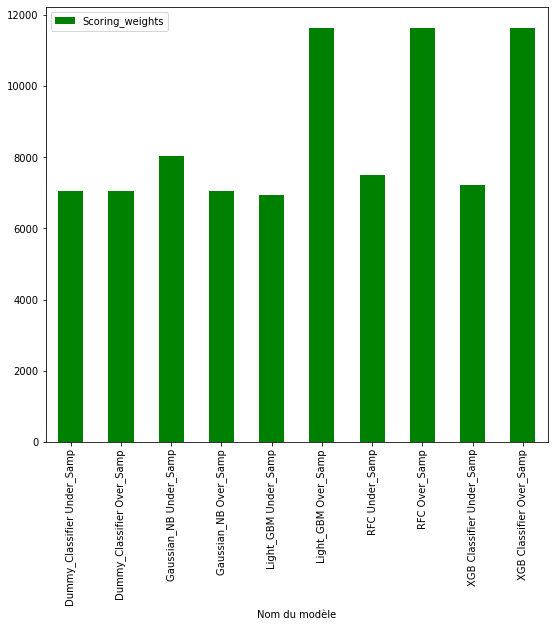

In [44]:
results.plot(x="Nom du modèle", y="Scoring_weights", kind="bar",figsize=(9,8), color='green')
plt.show()

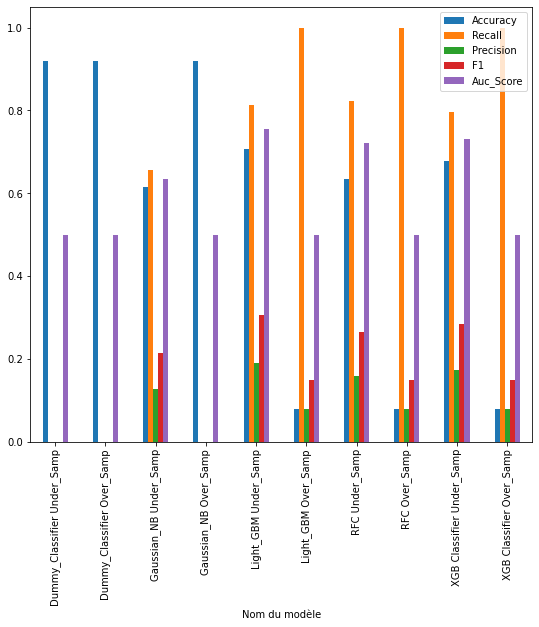

In [45]:
results.plot(x="Nom du modèle", y=results.columns[1:6], kind="bar",figsize=(9,8))
plt.show()

**Modèles Retenus**

Light GBM Under_Samp

RFC Under_Samp

XGB Under_Samp


**Optimisation des modèles**

In [46]:
custom_scorer = make_scorer(custom_metric, greater_is_better = False)

**Light GBM Under_Samp**

In [54]:
param_grid = {'num_leaves': np.arange(10, 100, 10), 
              'max_depth' : np.arange(5,15,5),
              'learning_rate': np.arange(0.2, 1.0, 0.2)
              }

model_opti(lgbm_class, "Light_GBM Under_Samp Opti", X_train_undersamp_std, y_train_undersamp, param_grid, 5)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test],
                                       'Best_params':[best_params]}))

lgbm_best_mdl = best_mdl

**XGB Under_Samp**

In [55]:
""" param_grid = {
    'n_estimators' : np.arange(50,500,50),
    'learning_rate': [0.01, 0.1]
    }

model_opti(xg, "XGB Under_Samp Opti", X_train_undersamp_std, y_train_undersamp, param_grid, 5)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test],
                                       'Best_params':[best_params]}))

xg_best_mdl = best_mdl """

' param_grid = {\n    \'n_estimators\' : np.arange(50,500,50),\n    \'learning_rate\': [0.01, 0.1]\n    }\n\nmodel_opti(xg, "XGB Under_Samp Opti", X_train_undersamp_std, y_train_undersamp, param_grid, 5)\n\nresults = results.append(pd.DataFrame({\'Nom du modèle\':[nm],\'Accuracy\':[accuracy],\'Recall\':[recall],\'Precision\':[precision],\'F1\':[f1],\n                                        \'Auc_Score\':[roc_auc],\'Scoring_weights\':[weights],\'Temps de train\':[elapsed_train], \'Temps de test\':[elapsed_test],\n                                       \'Best_params\':[best_params]}))\n\nxg_best_mdl = best_mdl '

**RFC Under_Sample**

In [56]:
""" param_grid = { 
    'n_estimators': np.arange(200, 1000,200),
    'max_depth' : np.arange(5,15,5)
}

model_opti(rf, "RFC Under_Samp Opti", X_train_undersamp_std, y_train_undersamp, param_grid, 5)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test],
                                       'Best_params':[best_params]}))

rfc_best_mdl = best_mdl """

' param_grid = { \n    \'n_estimators\': np.arange(200, 1000,200),\n    \'max_depth\' : np.arange(5,15,5)\n}\n\nmodel_opti(rf, "RFC Under_Samp Opti", X_train_undersamp_std, y_train_undersamp, param_grid, 5)\n\nresults = results.append(pd.DataFrame({\'Nom du modèle\':[nm],\'Accuracy\':[accuracy],\'Recall\':[recall],\'Precision\':[precision],\'F1\':[f1],\n                                        \'Auc_Score\':[roc_auc],\'Scoring_weights\':[weights],\'Temps de train\':[elapsed_train], \'Temps de test\':[elapsed_test],\n                                       \'Best_params\':[best_params]}))\n\nrfc_best_mdl = best_mdl '

**Interpretabilité des modèles**

In [57]:
results

,Nom du modèle,Accuracy,Recall,Precision,F1,Auc_Score,Scoring_weights,Temps de train,Temps de test,Best_params
0,Dummy_Classifier Under_Samp,0.919955,0.000000,0.000000,0.000000,0.500000,7054.000000,0.003884,0.001294,NaN
0,Dummy_Classifier Over_Samp,0.919955,0.000000,0.000000,0.000000,0.500000,7054.000000,0.032596,0.000874,NaN
0,Gaussian_NB Under_Samp,0.615775,0.656104,0.128338,0.214682,0.634185,8041.066667,0.070061,0.079452,NaN
0,Gaussian_NB Over_Samp,0.919841,0.000000,0.000000,0.000000,0.499938,7054.933333,0.649387,0.081896,NaN
0,Light_GBM Under_Samp,0.706274,0.813325,0.189314,0.307138,0.755143,6937.733333,5.516003,0.560846,NaN
0,Light_GBM Over_Samp,0.080045,1.000000,0.080045,0.148225,0.500000,11644.200000,36.093701,0.340050,NaN
0,RFC Under_Samp,0.633628,0.823888,0.157686,0.264709,0.720481,7509.200000,27.298260,2.316770,NaN
0,RFC Over_Samp,0.080045,1.000000,0.080045,0.148225,0.500000,11644.200000,504.498851,0.836537,NaN
0,XGB Classifier Under_Samp,0.678064,0.796262,0.172558,0.283647,0.732021,7208.266667,15.963758,0.305503,NaN
0,XGB Classifier Over_Samp,0.080045,1.000000,0.080045,0.148225,0.500000,11644.200000,274.867727,0.257242,NaN


**Meilleur modèle : Light_GBM Under_Samp Opti**

In [58]:
mdl_final = lgbm_best_mdl
mdl_final

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=90, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

**Interpreation via Shap**

100%|===================| 61468/61503 [11:01<00:00]       

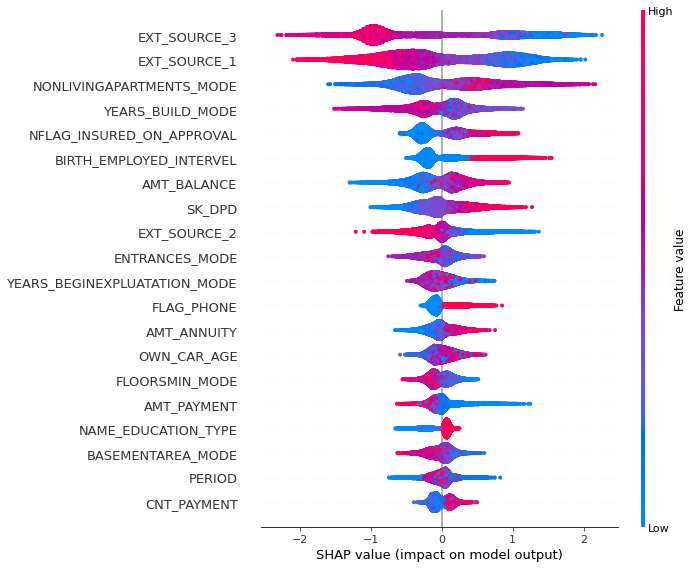

In [59]:
explainer = shap.Explainer(mdl_final, X_test_std)
val = explainer.shap_values(X_test_std)
shap.summary_plot(val, X_test_std)

**Réduction aux colonnes les plus importantes**

In [64]:
columns = ["EXT_SOURCE_1", "EXT_SOURCE_2","EXT_SOURCE_3","AMT_BALANCE","AMT_ANNUITY","AMT_DRAWINGS_CURRENT","AMT_CREDIT_MAX_OVERDUE",
           "CREDIT_DAY_OVERDUE","DAYS_CREDIT_ENDDATE","BIRTH_EMPLOYED_INTERVEL","SK_DPD",
           "NONLIVINGAPARTMENTS_MODE","YEARS_BUILD_MODE","ENTRANCES_MODE","BASEMENTAREA_MODE",
           "OWN_CAR_AGE","PERIOD","REG_CITY_NOT_WORK_CITY","CNT_PAYMENT","NFLAG_INSURED_ON_APPROVAL"]

In [65]:
X_train = X_train_undersamp[columns]
y_train = y_train_undersamp
X_test = X_test[columns]

In [66]:
X_train

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_ANNUITY,AMT_DRAWINGS_CURRENT,AMT_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,BIRTH_EMPLOYED_INTERVEL,SK_DPD,NONLIVINGAPARTMENTS_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,BASEMENTAREA_MODE,OWN_CAR_AGE,PERIOD,REG_CITY_NOT_WORK_CITY,CNT_PAYMENT,NFLAG_INSURED_ON_APPROVAL
0,0.083037,0.262949,0.139376,131079.249750,24700.5,16470.516557,1681.029000,0.000000,-349.000000,8824.0,-7.322679,0.000000,0.634100,0.069000,0.038300,20.423145,16.461104,0.0,24.000000,0.000000
2,0.549739,0.555912,0.729567,34694.255579,6750.0,11129.501304,0.000000,0.000000,-488.500000,18821.0,-0.784368,0.007421,0.775606,0.146614,0.080185,26.000000,20.000000,0.0,4.000000,0.000000
262152,0.429060,0.521588,0.410103,45556.210701,13500.0,9601.465900,0.000000,0.000000,-497.200000,6833.0,16.379038,0.008852,0.765436,0.145963,0.088079,15.000000,20.000000,0.0,11.600000,0.000000
12,0.464831,0.715042,0.176653,67189.913344,5881.5,2922.643044,0.000000,0.000000,-217.142857,10722.0,25.224443,-0.002449,0.728294,0.206900,0.090296,11.777135,13.749044,0.0,17.000000,0.333333
14,0.721940,0.642656,0.589452,58116.676475,32778.0,29924.947976,18873.270934,-0.063856,436.689816,14380.0,-1.979339,0.019500,0.980400,0.172400,0.138600,7.082227,23.603652,0.0,10.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262134,0.800999,0.739320,0.782608,181766.444872,62019.0,-2751.733949,27343.500000,0.000000,-952.285714,8209.0,-5.709664,0.000000,0.960800,0.137900,0.174000,11.000000,31.781744,0.0,21.500000,0.000000
262136,0.093508,0.269579,0.186293,99877.565163,24732.0,15179.371836,7360.298602,0.000000,-250.500000,9585.0,10.881521,0.000000,0.823600,0.103400,0.047700,17.000000,37.709971,1.0,14.000000,0.000000
262140,0.384668,0.579105,0.276441,60253.949609,10953.0,11240.225334,6667.582244,0.000000,677.500000,11078.0,36.111428,0.000000,0.843200,0.069000,0.052100,11.923036,20.542317,1.0,7.333333,0.000000
131069,0.577989,0.719671,0.431192,82233.542856,31473.0,41742.281700,0.000000,0.000000,1270.888889,16443.0,21.414431,0.017581,0.843557,0.172400,0.108603,4.000000,9.484701,0.0,7.500000,0.000000


In [67]:
X_test

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_ANNUITY,AMT_DRAWINGS_CURRENT,AMT_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,BIRTH_EMPLOYED_INTERVEL,SK_DPD,NONLIVINGAPARTMENTS_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,BASEMENTAREA_MODE,OWN_CAR_AGE,PERIOD,REG_CITY_NOT_WORK_CITY,CNT_PAYMENT,NFLAG_INSURED_ON_APPROVAL
234137,0.731439,0.603310,0.843544,10620.135000,16353.0,1730.769231,0.000000,0.000000,-1747.600000,387247.0,0.000000,0.039924,0.702977,0.083073,0.098473,10.918662,31.313154,0.0,19.636364,0.875000
244582,0.553803,0.564446,0.544235,114330.768234,38250.0,14802.689836,-85778.344134,0.000000,5282.500000,10075.0,-21.520713,0.014247,0.800839,0.139644,0.087307,6.322097,34.086588,1.0,12.000000,0.000000
60958,0.541634,0.091475,0.570917,75988.401684,15709.5,18546.559242,-20476.028828,0.000000,371.250000,389198.0,-7.866336,0.010307,0.739324,0.142064,0.077009,16.516120,16.213119,0.0,20.666667,0.333333
17422,0.630838,0.477592,0.331251,12741.221918,32584.5,-9364.718741,5670.253994,2.003072,72.787535,385642.0,27.720295,0.002901,0.755937,0.137900,0.063800,12.772938,26.150117,0.0,10.000000,1.000000
164889,0.147550,0.568592,0.432730,11351.548929,27958.5,35532.655714,108831.815639,8.244459,2494.903769,8641.0,0.000000,-0.013166,0.695600,0.217205,0.117142,15.539443,19.314341,1.0,14.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234861,0.500728,0.483410,0.803885,42888.270007,46629.0,5631.404778,11067.554589,0.000000,-521.500000,388188.0,32.109003,0.017248,0.763263,0.147049,0.079208,2.000000,23.536672,0.0,16.000000,0.333333
232922,0.402869,0.473327,0.307737,108554.905000,26982.0,18500.000000,0.000000,0.000000,386.454545,12935.0,0.000000,0.001012,0.777230,0.112995,0.092746,12.599737,18.345564,0.0,10.222222,0.333333
191594,0.425835,0.415446,0.522316,78538.380758,32602.5,24303.774918,5218.883543,0.558151,685.981452,10503.0,-4.216186,0.011067,0.788768,0.143295,0.082434,10.000000,20.703934,0.0,6.000000,0.000000
78357,0.457880,0.719106,0.567379,68075.507335,9000.0,16630.102420,0.000000,0.000000,-158.500000,8237.0,23.507846,0.003900,0.869300,0.034500,0.055500,11.097888,20.000000,1.0,6.000000,0.000000


In [68]:
y_train

0         1.0
2         0.0
262152    0.0
12        0.0
14        0.0
         ... 
262134    0.0
262136    0.0
262140    1.0
131069    0.0
131070    0.0
Name: TARGET, Length: 39804, dtype: float64

**Nouvel Entrainement sur le Dataset réduit avec le modèle optimal**

In [69]:
model(mdl_final, "Modele final",X_train, y_train, X_test)

results = results.append(pd.DataFrame({'Nom du modèle':[nm],'Accuracy':[accuracy],'Recall':[recall],'Precision':[precision],'F1':[f1],
                                        'Auc_Score':[roc_auc],'Scoring_weights':[weights],'Temps de train':[elapsed_train], 'Temps de test':[elapsed_test]}))

In [70]:
results

,Nom du modèle,Accuracy,Recall,Precision,F1,Auc_Score,Scoring_weights,Temps de train,Temps de test,Best_params
0,Dummy_Classifier Under_Samp,0.919955,0.000000,0.000000,0.000000,0.500000,7054.000000,0.003884,0.001294,NaN
0,Dummy_Classifier Over_Samp,0.919955,0.000000,0.000000,0.000000,0.500000,7054.000000,0.032596,0.000874,NaN
0,Gaussian_NB Under_Samp,0.615775,0.656104,0.128338,0.214682,0.634185,8041.066667,0.070061,0.079452,NaN
0,Gaussian_NB Over_Samp,0.919841,0.000000,0.000000,0.000000,0.499938,7054.933333,0.649387,0.081896,NaN
0,Light_GBM Under_Samp,0.706274,0.813325,0.189314,0.307138,0.755143,6937.733333,5.516003,0.560846,NaN
0,Light_GBM Over_Samp,0.080045,1.000000,0.080045,0.148225,0.500000,11644.200000,36.093701,0.340050,NaN
0,RFC Under_Samp,0.633628,0.823888,0.157686,0.264709,0.720481,7509.200000,27.298260,2.316770,NaN
0,RFC Over_Samp,0.080045,1.000000,0.080045,0.148225,0.500000,11644.200000,504.498851,0.836537,NaN
0,XGB Classifier Under_Samp,0.678064,0.796262,0.172558,0.283647,0.732021,7208.266667,15.963758,0.305503,NaN
0,XGB Classifier Over_Samp,0.080045,1.000000,0.080045,0.148225,0.500000,11644.200000,274.867727,0.257242,NaN


**Export Modèle et X_train**

In [71]:
pickle.dump(mdl_final,open("modele_final.pkl","wb"))
X_train.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/X_train.csv") 